# 4 Modeling: Breast Cancer Gene Expressions

## 4.1 Contents
* [4 Modeling](#4_modeling)
    * [4.1 Contents](#4.1_contents)
    * [4.2 Introduction](#4.2_intro)
    * [4.3 Imports](#4.3_imports)
    * [4.4 Loading the Data](#4.4_loading)

## 4.2 Introduction

## 4.3 Imports

In [1]:
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
#
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV 

#classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import pickle
import time 
print("Loaded Libraries")

Loaded Libraries


## 4.4 Loading the Data

In [2]:
# Load the NumPy arrays from the pickle files
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_190.pkl', 'rb') as file:
    X_train_190 = pickle.load(file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_190.pkl', 'rb') as file:
    X_test_190 = pickle.load(file)  
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_360.pkl', 'rb') as file:
    X_train_360 = pickle.load(file)  
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_360.pkl', 'rb') as file:
    X_test_360 = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_full.pkl', 'rb') as file:
    X_train_full = pickle.load(file) 

with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_full.pkl', 'rb') as file:
    X_test_full = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_train.pkl', 'rb') as file:
    y_train = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_test.pkl', 'rb') as file:
    y_test = pickle.load(file) 
    
# importing using parquet to preserve data types - this is the full dataset used to create the splits above

num_data=pd.read_parquet(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\num_data2.parquet', engine='pyarrow')

We have an imbalanced problem here: the class we are interested in (1, the patients who died of disease) are the minority class. As we saw in the EDA section, 33% of our data belongs to class 1.

As a solution to this, I am going to do resampling via the Synthetic Minority Over-sampling Technique (SMOTE), which synthesizes new data from within the minority class. It's an oversampling technique that should minimize overfitting. I also am going to try undersamping with NearMiss, and see how it compares. 


In [3]:
# Divide data into X and y

X=num_data.drop('outcome', axis=1)
y=num_data['outcome']

Do test train split:

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


<b> Oversampling </b>

In [5]:

# Implement SMOTE:

sm = SMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

In [6]:
# Confirming that our classes are now balanced

SMOTE_survival_counts = pd.Series(y_train_os).value_counts()
print('Outcomes:\n',100*SMOTE_survival_counts/len(y_train_os))

Outcomes:
 1    50.0
0    50.0
Name: outcome, dtype: float64


<b> Undersampling </b>

In [7]:
nm = NearMiss(version=1)
X_train_us, y_train_us = nm.fit_resample(X_train, y_train)

In [8]:
# Confirming that our classes are now balanced

undersampling_survival_counts = pd.Series(y_train_us).value_counts()
print('Outcomes:\n',100*undersampling_survival_counts/len(y_train_us))

Outcomes:
 0    50.0
1    50.0
Name: outcome, dtype: float64


I want to easily be able to compare all of the results, so I will append them to an empty I'm creating now dataframe, results_df:

In [9]:
results_df = pd.DataFrame(columns=['Model', 'Mean CV F1 Score', 'F1 Pos Class Score'] )

### Logistic Regression Base Model (no resampling)

This is our untuned logistic regression model on the data set with no resampling and no PCA. 

In [10]:
lr_model = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model.fit(X_train,y_train)
y_predict_test = lr_model.predict(X_test)

scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test))

[0.40837696 0.42391304 0.39130435 0.46601942 0.41489362]
Mean CV F1 score for the positive class: 0.42 (+/- 0.05)
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       320
           1       0.45      0.50      0.47       156

    accuracy                           0.64       476
   macro avg       0.60      0.60      0.60       476
weighted avg       0.65      0.64      0.64       476



In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test)
print(cm)

[[225  95]
 [ 78  78]]


In [12]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Base Model', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47


### Logistic Regression for Oversampled Data

In [13]:
lr_model_os = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model_os.fit(X_train_os, y_train_os)
y_predict_test_os = lr_model_os.predict(X_test)

scores = cross_val_score(lr_model_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_os))


[0.47435897 0.53211009 0.74879227 0.84513274 0.8590604 ]
Mean CV F1 score for the positive class: 0.69 (+/- 0.32)
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       320
           1       0.45      0.51      0.47       156

    accuracy                           0.63       476
   macro avg       0.59      0.60      0.60       476
weighted avg       0.65      0.63      0.64       476



In [14]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_os)
print(cm)

[[222  98]
 [ 77  79]]


This is almost the same as the base model

In [15]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Oversampled Model', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47


### Logistic Regression for Undersampled Data

In [16]:
lr_model_us = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model_us.fit(X_train_us, y_train_us)
y_predict_test_us = lr_model_us.predict(X_test)

scores = cross_val_score(lr_model_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_us))

[0.75138122 0.69512195 0.73298429 0.7357513  0.70422535]
Mean CV F1 score for the positive class: 0.72 (+/- 0.04)
              precision    recall  f1-score   support

           0       0.80      0.50      0.62       320
           1       0.42      0.74      0.53       156

    accuracy                           0.58       476
   macro avg       0.61      0.62      0.58       476
weighted avg       0.67      0.58      0.59       476



In [17]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_us)
print(cm)

[[161 159]
 [ 41 115]]


The undersampled data set actually performs better at correctly identifying cancer deaths.

In [18]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Undersampled Model', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.53}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53


### Logistic Regression - Hyperparameter Tuning 

In [19]:
# Define function to come up with cross validation scores: QUESTION - is this necessary or can I just use cross_val_score()?
def cv_score(clf, x, y, score_func = f1_score):
    result = 0
    nfold = 5
    x.reset_index(drop = True, inplace = True)
    y.index = x.index
    for train, test in KFold(nfold, shuffle = True,
                             random_state = 42).split(x):
        clf.fit(x.loc[train, :], y[train])
        result += score_func(clf.predict(x.loc[test, :]), y[test])
    return result / nfold

In [20]:
# Convert X_train_os and y_train to pandas DataFrames
X_train_os_df = pd.DataFrame(X_train_os)
y_train_os_df = pd.Series(y_train_os)
X_test_df = pd.DataFrame(X_test)
y_test_df=pd.Series(y_test)

# Convert X_train_us to pandas DataFrame
X_train_us_df = pd.DataFrame(X_train_us)
y_train_us_df = pd.DataFrame(y_train_us)

In [21]:
# Hyperparameter tuning using grid search

params={
    'penalty':['l1','l2'],
    'C':[0.001, 0.1, 1, 10, 100],
    }

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

#  do GridSearchCV
grid_search= GridSearchCV(estimator=logreg,param_grid=params,cv=5, scoring='f1', n_jobs=-1)

# Oversampled Data
grid_search.fit(X_train_os,y_train_os)

# print best hyperparameters and F1 score
print("Best hyperparameters for oversampled data:", grid_search.best_params_)
print("Accuracy score for oversampled data:", grid_search.best_score_)

# Undersampled data
grid_search.fit(X_train_us,y_train_us)

# print best hyperparameters and F1 score
print("\nBest hyperparameters for undersampled data:", grid_search.best_params_)
print("F1 score for undersampled data:", grid_search.best_score_)



Best hyperparameters for oversampled data: {'C': 0.1, 'penalty': 'l1'}
Accuracy score for oversampled data: 0.7247556744079577

Best hyperparameters for undersampled data: {'C': 0.001, 'penalty': 'l2'}
F1 score for undersampled data: 0.7697456598473039


### Logistic Regression with new hyperparameters:

<b> Oversampled Data </b>

changing solver to 'liblinear' as it supports l1 penalty, and 'saga' got convergence errors with the same result

In [22]:
lr_model_os_tuned = LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l1') 
lr_model_os_tuned.fit(X_train_os, y_train_os)
y_predict_test_tuned_os = lr_model_os.predict(X_test)

scores = cross_val_score(lr_model_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_tuned_os))


[0.53250774 0.59235669 0.76683938 0.86896552 0.86310905]
Mean CV F1 score for the positive class: 0.72 (+/- 0.28)
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       320
           1       0.45      0.51      0.47       156

    accuracy                           0.63       476
   macro avg       0.59      0.60      0.60       476
weighted avg       0.65      0.63      0.64       476



In [23]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_tuned_os)
print(cm)

[[222  98]
 [ 77  79]]


In [24]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Oversampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47


<b> Oversampled Data </b>

In [25]:
lr_model_us_tuned = LogisticRegression(solver = 'newton-cg', max_iter = 500, C=0.001, penalty='l2') 
lr_model_us_tuned.fit(X_train_us, y_train_us)
y_predict_test_tuned_us = lr_model_us.predict(X_test)

scores = cross_val_score(lr_model_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_tuned_us))


[0.8502994  0.71428571 0.77966102 0.75824176 0.7254902 ]
Mean CV F1 score for the positive class: 0.77 (+/- 0.10)
              precision    recall  f1-score   support

           0       0.80      0.50      0.62       320
           1       0.42      0.74      0.53       156

    accuracy                           0.58       476
   macro avg       0.61      0.62      0.58       476
weighted avg       0.67      0.58      0.59       476



In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_tuned_us)
print(cm)

[[161 159]
 [ 41 115]]


In [27]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Undersampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.53}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53


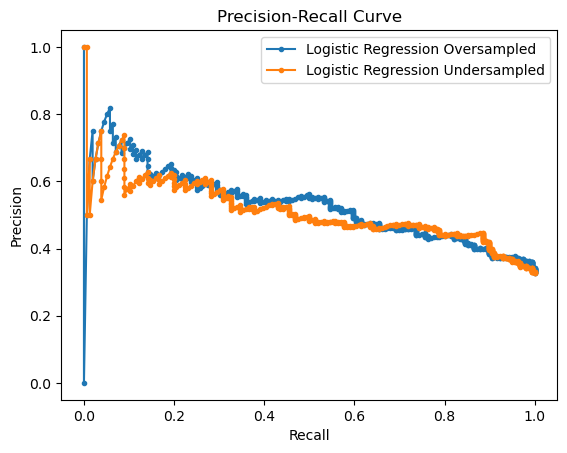

In [28]:
models = {
    'Logistic Regression Oversampled': LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l1'),
    'Logistic Regression Undersampled': LogisticRegression(solver = 'newton-cg', max_iter = 500, C=0.001, penalty='l2'),
}

training_data = {
    'Logistic Regression Oversampled': (X_train_os, y_train_os),
    'Logistic Regression Undersampled': (X_train_us, y_train_us),
}

# Use the same test data for both models
testing_data = X_test

for name, model in models.items():
    X_train_res, y_train_res = training_data[name]
    model.fit(X_train_res, y_train_res) # Use the resampled y_train data
    y_scores = model.predict_proba(testing_data)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, marker='.', label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


# Random Forest Classifier Model

<b> Oversampled </b>

In [29]:
# Create the model
rfc_os = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rfc_os.fit(X_train_os, y_train_os)

# Predict the labels of the test set
y_predict_test_os_rf = rfc_os.predict(X_test)


scores = cross_val_score(rfc_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test classification report, all components: 
print('Random Forest Model: Test data, Oversampled:\n',classification_report(y_test,y_predict_test_os_rf))


[0.67283951 0.69538462 0.82539683 0.89371981 0.88674699]
Mean CV F1 score for the positive class: 0.79 (+/- 0.19)
Random Forest Model: Test data, Oversampled:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79       320
           1       0.53      0.31      0.40       156

    accuracy                           0.68       476
   macro avg       0.63      0.59      0.59       476
weighted avg       0.66      0.68      0.66       476



In [30]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_os_rf)
print(cm)

[[277  43]
 [107  49]]


In [31]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Oversampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.40}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40


<b> Undersampled </b>

In [32]:
# Create the model
rfc_us = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rfc_us.fit(X_train_us, y_train_us)

# Predict the labels of the test set
y_predict_test_us_rf = rfc_us.predict(X_test)


scores = cross_val_score(rfc_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)
print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Test classification report, all components: 
print('Random Forest Model: Test data, Undersampled:\n',classification_report(y_test,y_predict_test_us_rf))


[0.83950617 0.72839506 0.75       0.74509804 0.69194313]
Mean CV F1 score for the positive class: 0.75 (+/- 0.10)
Random Forest Model: Test data, Undersampled:
               precision    recall  f1-score   support

           0       0.77      0.45      0.57       320
           1       0.39      0.72      0.51       156

    accuracy                           0.54       476
   macro avg       0.58      0.59      0.54       476
weighted avg       0.65      0.54      0.55       476



In [33]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_us_rf)
print(cm)

[[145 175]
 [ 43 113]]


In [34]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Undersampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.51}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51


### Hyperparameter tuning

<b> Oversampled </b>

In [35]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rfc_os = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc_os, param_grid = param_grid, 
                           cv = 5, scoring='f1', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_os, y_train_os)

# Get the best parameters
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


<b> Tuning the model </b>

In [36]:
# Create the model
rfc_os_tuned = RandomForestClassifier(n_estimators=300, max_depth=10,min_samples_leaf=2,min_samples_split=2, random_state=42)

# Fit the model
rfc_os_tuned.fit(X_train_os, y_train_os)

# Predict the labels of the test set
y_predict_test_os_rf_tuned = rfc_os_tuned.predict(X_test)


scores = cross_val_score(rfc_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test classification report, all components: 
print('Random Forest Model: Test data, Oversampled:\n',classification_report(y_test,y_predict_test_os_rf_tuned))


[0.73802817 0.77746479 0.81841432 0.88056206 0.8591224 ]
Mean CV F1 score for the positive class: 0.81 (+/- 0.10)
Random Forest Model: Test data, Oversampled:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       320
           1       0.51      0.46      0.49       156

    accuracy                           0.68       476
   macro avg       0.63      0.62      0.63       476
weighted avg       0.67      0.68      0.68       476



In [37]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_os_rf_tuned)
print(cm)

[[252  68]
 [ 84  72]]


In [38]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Oversampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.49}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49


<b> Undersampled, Tuned </b>

In [39]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rfc_us = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc_us, param_grid = param_grid, 
                           cv = 5, scoring='f1', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_us, y_train_us)

# Get the best parameters
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [40]:
# Create the model
rfc_us_tuned = RandomForestClassifier(n_estimators=300, max_depth=10,min_samples_leaf=4,min_samples_split=2, random_state=42)

# Fit the model
rfc_us_tuned.fit(X_train_us, y_train_us)

# Predict the labels of the test set
y_predict_test_us_rf_tuned = rfc_us_tuned.predict(X_test)


scores = cross_val_score(rfc_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test classification report, all components: 
print('Random Forest Model: Test data, Oversampled:\n',classification_report(y_test,y_predict_test_us_rf_tuned))


[0.84146341 0.73619632 0.80446927 0.75247525 0.71497585]
Mean CV F1 score for the positive class: 0.77 (+/- 0.09)
Random Forest Model: Test data, Oversampled:
               precision    recall  f1-score   support

           0       0.79      0.47      0.59       320
           1       0.41      0.74      0.52       156

    accuracy                           0.56       476
   macro avg       0.60      0.61      0.56       476
weighted avg       0.66      0.56      0.57       476



In [41]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_us_rf_tuned)
print(cm)

[[150 170]
 [ 40 116]]


In [42]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Undersampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.52}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52


# XG Boost Model

<b> Oversampled model </b>

In [43]:
# fit model
xgboost_model_os = XGBClassifier()
xgboost_model_os.fit(X_train_os, y_train_os)

# make predictions for test data
xgboost_y_pred_os = xgboost_model_os.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_os]


scores = cross_val_score(xgboost_model_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Oversampled',classification_report(y_test, xgboost_y_pred_os))

[0.60450161 0.72072072 0.81794195 0.89719626 0.89929742]
Mean CV F1 score for the positive class: 0.79 (+/- 0.23)
Test Classification Report, XG Boost, Oversampled               precision    recall  f1-score   support

           0       0.75      0.83      0.79       320
           1       0.55      0.43      0.48       156

    accuracy                           0.70       476
   macro avg       0.65      0.63      0.64       476
weighted avg       0.69      0.70      0.69       476



In [44]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_os)
print(cm)

[[266  54]
 [ 89  67]]


In [45]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Oversampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.48}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


<b>Undersampled Model</b>

In [46]:
# fit model
xgboost_model_us = XGBClassifier()
xgboost_model_us.fit(X_train_us, y_train_us)

# make predictions for test data
xgboost_y_pred_us = xgboost_model_us.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_us]


scores = cross_val_score(xgboost_model_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Undersampled',classification_report(y_test, xgboost_y_pred_us))

[0.82840237 0.72392638 0.74193548 0.75126904 0.71428571]
Mean CV F1 score for the positive class: 0.75 (+/- 0.08)
Test Classification Report, XG Boost, Undersampled               precision    recall  f1-score   support

           0       0.81      0.49      0.61       320
           1       0.43      0.77      0.55       156

    accuracy                           0.58       476
   macro avg       0.62      0.63      0.58       476
weighted avg       0.69      0.58      0.59       476



In [47]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_us)
print(cm)

[[158 162]
 [ 36 120]]


In [48]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Undersampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.55}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


NOTE: This is the best one so far, as far as the F1 score goes

### Hyperparameter Tuning

<b> Oversampled </b>

In [49]:
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the classifier
xgboost_model_os = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model_os, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_os, y_train_os)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}
0.7998481713612512


Apply the tuned hyperparameters:

In [50]:
# fit model
xgboost_model_os_tuned = XGBClassifier()
xgboost_model_os_tuned.fit(X_train_os, y_train_os)

# make predictions for test data
xgboost_y_pred_os_tuned = xgboost_model_os_tuned.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_os_tuned]


scores = cross_val_score(xgboost_model_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Oversampled, Tuned',classification_report(y_test, xgboost_y_pred_os_tuned))

[0.60450161 0.72072072 0.81794195 0.89719626 0.89929742]
Mean CV F1 score for the positive class: 0.79 (+/- 0.23)
Test Classification Report, XG Boost, Oversampled, Tuned               precision    recall  f1-score   support

           0       0.75      0.83      0.79       320
           1       0.55      0.43      0.48       156

    accuracy                           0.70       476
   macro avg       0.65      0.63      0.64       476
weighted avg       0.69      0.70      0.69       476



In [51]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_os_tuned)
print(cm)

[[266  54]
 [ 89  67]]


In [52]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Oversampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.48}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


<b> Undersampled </b>

In [53]:
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the classifier
xgboost_model_us_tuned = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model_us_tuned, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_us, y_train_us)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}
0.7621981384459869


Applying the tuned hyperparameters:

In [54]:
# fit model
xgboost_model_us_tuned = XGBClassifier(gamma= 0, learning_rate=0.05, max_depth= 6, min_child_weight=1, n_estimators=200)
xgboost_model_us_tuned.fit(X_train_us, y_train_us)

# make predictions for test data
xgboost_y_pred_us_tuned = xgboost_model_us_tuned.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_us_tuned]


scores = cross_val_score(xgboost_model_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Undersampled, Tuned',classification_report(y_test, xgboost_y_pred_us_tuned))

[0.82142857 0.73493976 0.77777778 0.76530612 0.71153846]
Mean CV F1 score for the positive class: 0.76 (+/- 0.08)
Test Classification Report, XG Boost, Undersampled, Tuned               precision    recall  f1-score   support

           0       0.84      0.50      0.63       320
           1       0.44      0.81      0.57       156

    accuracy                           0.60       476
   macro avg       0.64      0.65      0.60       476
weighted avg       0.71      0.60      0.61       476



In [55]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_us_tuned)
print(cm)

[[160 160]
 [ 30 126]]


In [56]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Undersampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.57}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


XG Boost, undersampled and tuned is the best so far!

# LGBM Model

<b> Oversampled </b>

In [57]:
# using this method: https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

#create the model

lgbm_model_os= LGBMClassifier()

# fit the model
lgbm_model_os.fit(X_train_os, y_train_os)

# make predictions for test data
lgbm_y_pred_os = lgbm_model_os.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_os]


scores = cross_val_score(lgbm_model_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Oversampled',classification_report(y_test, lgbm_y_pred_os))

[0.61073826 0.64761905 0.82414698 0.90140845 0.89671362]
Mean CV F1 score for the positive class: 0.78 (+/- 0.25)
Test Classification Report, LGBM, Oversampled               precision    recall  f1-score   support

           0       0.75      0.83      0.79       320
           1       0.56      0.43      0.49       156

    accuracy                           0.70       476
   macro avg       0.65      0.63      0.64       476
weighted avg       0.69      0.70      0.69       476



In [58]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_os)
print(cm)

[[267  53]
 [ 89  67]]


In [59]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Oversampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.49}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


<b> Undersampled </b>

In [60]:
#create the model

lgbm_model_us= LGBMClassifier()

# fit the model
lgbm_model_us.fit(X_train_us, y_train_us)

# make predictions for test data
lgbm_y_pred_us = lgbm_model_us.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_us]


scores = cross_val_score(lgbm_model_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Undersampled',classification_report(y_test, lgbm_y_pred_us))

[0.82352941 0.73619632 0.75280899 0.75376884 0.71962617]
Mean CV F1 score for the positive class: 0.76 (+/- 0.07)
Test Classification Report, LGBM, Undersampled               precision    recall  f1-score   support

           0       0.84      0.49      0.62       320
           1       0.44      0.81      0.57       156

    accuracy                           0.59       476
   macro avg       0.64      0.65      0.59       476
weighted avg       0.71      0.59      0.60       476



In [61]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_us)
print(cm)

[[157 163]
 [ 30 126]]


In [62]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Undersampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.57}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


### Hyperparameter tuning

In [63]:
grid = {
    'num_leaves': [31, 127],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the classifier
lgbm_model_os = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model_os, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_os, y_train_os)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 31}
0.8006962542460357


In [64]:
# apply the tuned hyperparameters:

lgbm_model_os_tuned= LGBMClassifier(num_leaves=31,min_child_samples=20,max_depth=7,learning_rate=0.2)

# fit the model
lgbm_model_os_tuned.fit(X_train_os, y_train_os)

# make predictions for test data
lgbm_y_pred_os_tuned = lgbm_model_os_tuned.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_os_tuned]


scores = cross_val_score(lgbm_model_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Oversampled',classification_report(y_test, lgbm_y_pred_os_tuned))

[0.67507886 0.68125    0.82506527 0.91428571 0.90780142]
Mean CV F1 score for the positive class: 0.80 (+/- 0.21)
Test Classification Report, LGBM, Oversampled               precision    recall  f1-score   support

           0       0.74      0.83      0.78       320
           1       0.54      0.39      0.45       156

    accuracy                           0.69       476
   macro avg       0.64      0.61      0.62       476
weighted avg       0.67      0.69      0.67       476



In [65]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_os_tuned)
print(cm)

[[267  53]
 [ 95  61]]


In [66]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Oversampled, tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.45}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


<b>Undersampled</b>

In [67]:
grid = {
    'num_leaves': [31, 127],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the classifier
lgbm_model_us = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model_us, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_us, y_train_us)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 31}
0.7612449110387799


In [68]:
# apply the tuned hyperparameters:

lgbm_model_us_tuned= LGBMClassifier(num_leaves=31,min_child_samples=20,max_depth=7,learning_rate=0.2)

# fit the model
lgbm_model_us_tuned.fit(X_train_us, y_train_us)

# make predictions for test data
lgbm_y_pred_us_tuned = lgbm_model_us_tuned.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_us_tuned]


scores = cross_val_score(lgbm_model_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Undersampled',classification_report(y_test, lgbm_y_pred_us_tuned))

[0.83529412 0.71604938 0.76300578 0.75757576 0.73429952]
Mean CV F1 score for the positive class: 0.76 (+/- 0.08)
Test Classification Report, LGBM, Undersampled               precision    recall  f1-score   support

           0       0.81      0.50      0.62       320
           1       0.42      0.76      0.54       156

    accuracy                           0.58       476
   macro avg       0.62      0.63      0.58       476
weighted avg       0.68      0.58      0.59       476



In [69]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_us_tuned)
print(cm)

[[160 160]
 [ 38 118]]


In [70]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Undersampled, tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.54}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


This is actually worse than when it was untuned.

In [71]:
# Sort results by F1 pos class score
results_df.sort_values(by='F1 Pos Class Score')

,Model,Mean CV F1 Score,F1 Pos Class Score
5,"Random Forest, Oversampled",0.79,0.40
15,"LGBM Model, Oversampled, tuned",0.80,0.45
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
11,"XG Boost, Oversampled, Tuned",0.79,0.48
9,"XG Boost, Oversampled",0.79,0.48
13,"LGBM Model, Oversampled",0.78,0.49
7,"Random Forest, Oversampled, Tuned",0.81,0.49
6,"Random Forest, Undersampled",0.75,0.51


In [72]:
# Sort results by mean CV F1 score
results_df.sort_values(by='Mean CV F1 Score')

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
6,"Random Forest, Undersampled",0.75,0.51
10,"XG Boost, Undersampled",0.75,0.55
14,"LGBM Model, Undersampled",0.76,0.57
12,"XG Boost, Undersampled, Tuned",0.76,0.57
16,"LGBM Model, Undersampled, tuned",0.76,0.54
4,"Logistic Regression Undersampled, Tuned",0.77,0.53


<b>CONCLUSION:</b>

If we are looking at the F1 Positive Class Score, the XG Boost, Undersampled & Tuned, as well as the LGBM, Undersampled (not tuned) performed the best.

If we are looking at the Mean CV F1 score, the Random Forest, Oversampled & Tuned performed the best, but it should be noted that the F1 Pos Class Score was much worse. 

When looking at all of the scoring data (classification reports & confusion matrix), overall I think that the XG Boost. Undersampled & Tuned, is the best model. 